In [1]:
# include("../src/DiffusionMLE.jl")
using DiffusionMLE, Plots

# Introduction

This is a minimal example on how to apply our maximum likelihood estimator to a set of heterogeneous single-particle tracking data.  Here, "heterogeneous" refers to the fact that the data originate from subpopulations with differing diffusion coefficients.  

The code relevant for the analysis of heterogeneous data exploits threading, so it is recommended to run the command <code>export JULIA_NUM_THREADS=n</code>, with <code>n</code> being the number of available (physical) cores, before launching Julia.  This speeds up the numerics significantly.  

For more details on the theoretical framework, please refer to the associated preprint:
> J. T. Bullerjahn and G. Hummer, "Maximum likelihood estimates of diffusion coefficients from single-molecule tracking experiments", https://arxiv.org/abs/2011.09955

# Generate trajectories

Each trajectory can be seen as a $d$-dimensional array (<code>Array{Float64,2}</code>), so the data set should be of the type <code>Array{Array{Float64,2},1}</code>.  

Here, we generate mock data, made up of $M$ $d$-dimensional trajectories of different lengths $N = \{N_{1}, N_{2}, \dots, N_{M}\}$.  The $N_{i}$ are distributed uniformly on the interval $[3,100]$.  The data form a $3:4:3$-mixture of trajectories generated using three distinct diffusive dynamics.  

In [3]:
include("smeared_trajectory_integrator.jl")

const M = 1000 # Number of trajectories
const d = 2 # Dimension of trajectories

const N_sub = 100 # Number of substeps over which the trajectory is smeared out

N = [ rand(3:100) for i = 1 : M ] # Array of trajectory lengths

# Consider three subpopulations, characterized by the following parameters:
const a2_1 = 0.5
const a2_2 = 2.0
const a2_3 = 1.0
const σ2_1 = 0.1
const σ2_2 = 1.0
const σ2_3 = 10.0

B = [1/6 for m = 1 : M] # Array of blurring coefficients, where we have assumed a uniform illumination profile
data = vcat([make_2D_data(N[1:300],N_sub,a2_1,σ2_1), 
        make_2D_data(N[301:700],N_sub,a2_2,σ2_2), 
        make_2D_data(N[701:1000],N_sub,a2_3,σ2_3)]...); # Mock data set

# Analyzing the data

In [4]:
function print_results(estimates,uncertainties)
    K = size(estimates,2)
    for k = 1 : K
        println(string("a2_", k, " = ", estimates[1,k], " ± ", uncertainties[1,k]))
    end
    for k = 1 : K
        println(string("σ2_", k, " = ", estimates[2,k], " ± ", uncertainties[2,k]))
    end
    for k = 1 : K
        println(string("P_", k, " = ", estimates[3,k]))
    end
end

const N_local = 500 # Max number of expectation-maximization cycles
const N_global = 100 # Number of iterations with different initial parameters

# Ranges from which the initial values for the parameters are drawn:
a2_range = [ 0.01, 20. ]
σ2_range = [ 0.01, 20. ];

### Available cores for threading

In [5]:
using Base.Threads
println(string("Number of available cores for threading: ", nthreads()))

Number of available cores for threading: 1


### Assuming a single population

Estimates:
a2_1 = 1.2544890390901853 ± 0.01567425800098078
σ2_1 = 3.412094512180118 ± 0.026119656854582722
P_1 = 1.0

Kuiper statistic:
κ = 24.585842241513763


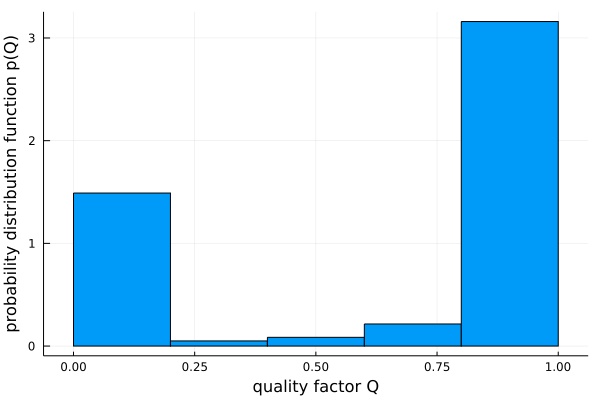


(process:3272): GLib-GIO-WARNING **: 03:30:51.174: Unexpectedly, UWP app `HaukeGtze.7-ZipFileManagerUnofficial_1.1900.3.0_x64__6bk20wvc8rfx2' (AUMId `HaukeGtze.7-ZipFileManagerUnofficial_6bk20wvc8rfx2!zFM.exe') supports 36 extensions but has no verbs


In [7]:
parameters = MLE_estimator(B,data)
parameter_matrix = reshape(vcat([parameters,[1.0]]...), 3, 1)
P1_estimates, P1_L, P1_T = local_EM_estimator!(d,M,1,N_local,parameter_matrix,B,data)
P1_uncertainties = MLE_errors(B,data,parameters)

println("Estimates:")
print_results(P1_estimates,P1_uncertainties)

Q_sub = subpopulation_analysis(P1_T,P1_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("κ = ",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false, 
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The distribution of quality factors, which should be uniform, and the associated Kuiper statistic reveal that a single-population model does not suffice.  

### Assuming two subpopulations

In [8]:
P2_estimates, P2_L, P2_T = global_EM_estimator(2,N_local,N_global,a2_range,σ2_range,B,data);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


Estimates:
a2_1 = 0.5018079269826856 ± 0.005421566363010789
a2_2 = 1.5703966165722092 ± 0.024865530131002116
σ2_1 = 0.10396711421629683 ± 0.002303323028212447
σ2_2 = 4.8096355890626175 ± 0.043303374976187844
P_1 = 0.30497187701726886
P_2 = 0.6950281229827312

Kuiper statistic:
K=18.095655443984448


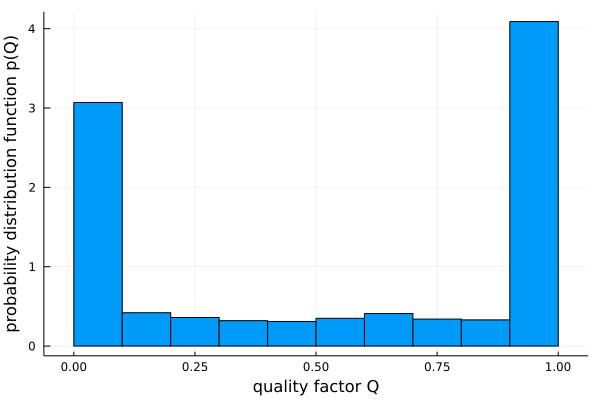

In [9]:
B_sub, X_sub = sort_trajectories(2,P2_T,B,data)
P2_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P2_estimates[1:2,k]) for k = 1 : 2 ]...)

println("Estimates:")
print_results(P2_estimates,P2_uncertainties)

Q_sub = subpopulation_analysis(P2_T,P2_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false, bins=10,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The Kuiper statistic is slightly better, but overall a two-population model cannot explain the data.  

### Assuming three subpopulations

In [10]:
P3_estimates, P3_L, P3_T = global_EM_estimator(3,N_local,N_global,a2_range,σ2_range,B,data);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


Estimates:
a2_1 = 1.0155896940067348 ± 0.05239293205817071
a2_2 = 1.9625266180375953 ± 0.021530618016608355
a2_3 = 0.5010655317683659 ± 0.005417789428694362
σ2_1 = 9.980670570347138 ± 0.12510681419655087
σ2_2 = 1.025002342291558 ± 0.015998134992523543
σ2_3 = 0.1036271232687419 ± 0.0022984944437858946
P_1 = 0.2988275262135425
P_2 = 0.39970427404790526
P_3 = 0.3014681997385522

Ground truth (up to permutations):
a2_1 = 0.5
a2_2 = 2.0
a2_3 = 1.0
σ2_1 = 0.1
σ2_2 = 1.0
σ2_3 = 10.0

Kuiper statistic:
K=0.8452668495426754


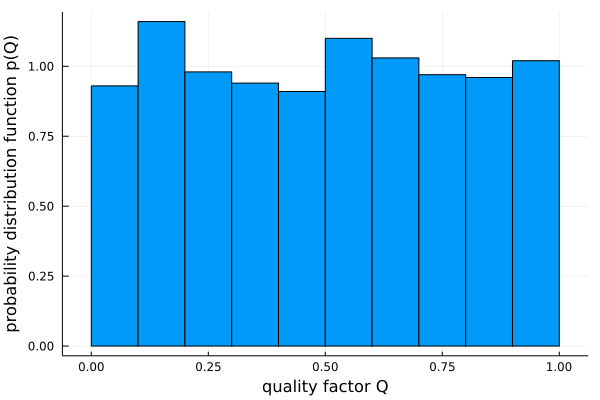

In [11]:
B_sub, X_sub = sort_trajectories(3,P3_T,B,data)
P3_uncertainties = hcat([ MLE_errors(B_sub[k], X_sub[k], P3_estimates[1:2,k]) for k = 1 : 3 ]...)

println("Estimates:")
print_results(P3_estimates,P3_uncertainties)

println()

println("Ground truth (up to permutations):")
println(string("a2_1 = ", a2_1))
println(string("a2_2 = ", a2_2))
println(string("a2_3 = ", a2_3))
println(string("σ2_1 = ", σ2_1))
println(string("σ2_2 = ", σ2_2))
println(string("σ2_3 = ", σ2_3))

Q_sub = subpopulation_analysis(P3_T,P3_estimates,B,data)
Q = vcat(Q_sub...)

println()

println("Kuiper statistic:")
println("K=",Kuiper_statistic!(Q))

histogram(Q, normed=true, legend=false,
    xlabel="quality factor Q", 
    ylabel="probability distribution function p(Q)")

The quality factors are uniformly distributed, and the Kuiper statistic evaluates close to unity for the three-population model.  

### Diffusion coefficients

Diffusion coefficients can be extracted from the $\sigma^2$-values, irrespective of the dimension $d$, as follows:
\begin{equation*}
D = \frac{\sigma^2}{2 \Delta t} \, .  
\end{equation*}
Here, $\sigma$ has the same dimension as the data, i.e., if the trajectories are recorded on the nanometer scale then $[\sigma] = \textrm{nm}$, and $\Delta t$ denotes the time step between two observations.  